# Deloitte's Quantum Climate Challenge 2023

The challenge focuses on CO2 captuere in MOFs (Metal Organic Frameworks) ans is dvided in two principal tasks

## Task 1: Calculate the minimum of the potential energy surface of combinations gas molecules and metallic ions

### Task 1A: Build a quantum/quantum-hybrid algorithm. Run simulations and on real quantum devices

Pick at least one metallic ion from the list:
* __Mg2+ (2p6 - 10 e-)__
* Mn2+ (3d5 - 23 e-)
* Fe2+ (3d6 - 24 e-)
* Co2+ (3d7 - 25 e-)
* Ni2+ (3d8 - 26 e-)
* Cu2+ (3d9 - 27 e-)
* __Zn2+ (3d10 - 28 e-)__

And study the composite system with CO2 and another gas molecule:
* __CO2 (22 e-)__
* __H2O (10 e-)__
* __N2 (14e-)__


### Task 1B: Compare those results to classical simulations

This notebook Plots the results from the simulations with Qiskit, PySCF and real hardware results

### Imports and Helper Functions

In [401]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver #Algorithms

#Qiskit odds and ends
from qiskit.circuit.library import EfficientSU2, EvolvedOperatorAnsatz
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient, NaturalGradient
from qiskit import IBMQ, BasicAer, Aer, transpile
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.algorithms.minimum_eigensolvers import VQE, AdaptVQE, MinimumEigensolverResult
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.quantum_info import SparsePauliOp

#qiskit_nature
from qiskit_nature.second_q.drivers import PySCFDriver, MethodType
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.circuit.library import UCCSD, PUCCD, SUCCD, HartreeFock, CHC, VSCF
from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer , FreezeCoreTransformer
from qiskit_nature.second_q.problems import ElectronicStructureProblem, EigenstateResult
from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.vqe_ucc_factory import VQEUCCFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.numpy_minimum_eigensolver_factory import NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.excited_states_solvers.eigensolver_factories.numpy_eigensolver_factory import NumPyEigensolverFactory
from qiskit_nature.second_q.algorithms.excited_states_solvers import QEOM, ExcitedStatesEigensolver

#Runtime
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit_ibm_runtime.options import Options, ResilienceOptions, SimulatorOptions, TranspilationOptions, ExecutionOptions

#PySCF
from functools import reduce
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci
from functools import reduce
from pyscf.mcscf import avas, dmet_cas

#Python odds and ends
import matplotlib
import matplotlib.pyplot as plt
import pylab
import numpy as np
import os
import pyscf
from IPython.display import display, clear_output
import mapomatic as mm

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(group='deployed')
service = QiskitRuntimeService(channel='ibm_quantum')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Real Devices
backend_nair= provider.get_backend('ibm_nairobi')
backend_manil = provider.get_backend('ibmq_manila')
backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')
seed=42

#solvers
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()

ibmqfactory.load_account:WARNING:2023-03-07 20:06:13,964: Credentials are already in use. The existing account in the session will be replaced.


Helper functions to save and read results

In [402]:
## Python program to store list to file using pickle module
import pickle

# write list to binary file
def write_list(a_list,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')
        
def write_dict(a_dict,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_dict, fp,protocol=pickle.HIGHEST_PROTOCOL)
        print('Done writing dict into a binary file')

# Read list to memory
def read(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [403]:
import scipy.interpolate as interp
from scipy.optimize import minimize_scalar

def interpolate_pes(xdata,ydata):
    newx=xdata
    newy=ydata

    tck = interp.splrep(newx, newy, k=3)

    popt = lambda x: interp.splev(x, tck)
    popt_d = lambda x: interp.splev(x, tck, der=1)

    result = minimize_scalar(popt)
    assert result.success

    min_x = result.x
    min_val = result.fun
    x_left = min(newx)
    x_right = max(newy)
    
    my_dict={'popt':popt,
             'popt_d':popt_d,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right
    }

    return my_dict


## MG+H2O

We define a fitting function for this pair:

In [745]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=1.8,u0=-275)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 1

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 0.3
    morse_o_params['re'].max = 3
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [746]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Mg+H2O/simulations/ryrz_results')[1:10]
uccsd_results=read('Mg+H2O/simulations/uccsd_results')[1:10]
avqe_results=read('Mg+H2O/simulations/avqe_results')[1:10]
classic_results=read('Mg+H2O/simulations/classic_results')[1:10]
pyscf_energies=read('Mg+H2O/simulations/pyscf_energies')[1:10]
problems=read('Mg+H2O/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])
            

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [747]:
len(distances)

9

Read the PySCF simulation results

In [748]:
HF_engs=read('Mg+H2O/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Mg+H2O/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Mg+H2O/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [749]:
interpreted_results=read('Mg+H2O/VQE_results/interpreted_results')[1:10]
rdistances=np.arange(0.6,3.1,0.3)
montreal_energies=[]
for i in range(len(rdistances)):
            montreal_energies.append(interpreted_results[i].total_energies[0])

real_engs={'montreal':montreal_energies}

interpolate all the data

In [750]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [751]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [752]:
real_interp={}

real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [753]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [754]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [755]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

(<matplotlib.patches.Rectangle at 0x2e67074c0>,
 (<matplotlib.patches.ConnectionPatch at 0x2e5da9580>,
  <matplotlib.patches.ConnectionPatch at 0x2e5dc5520>))

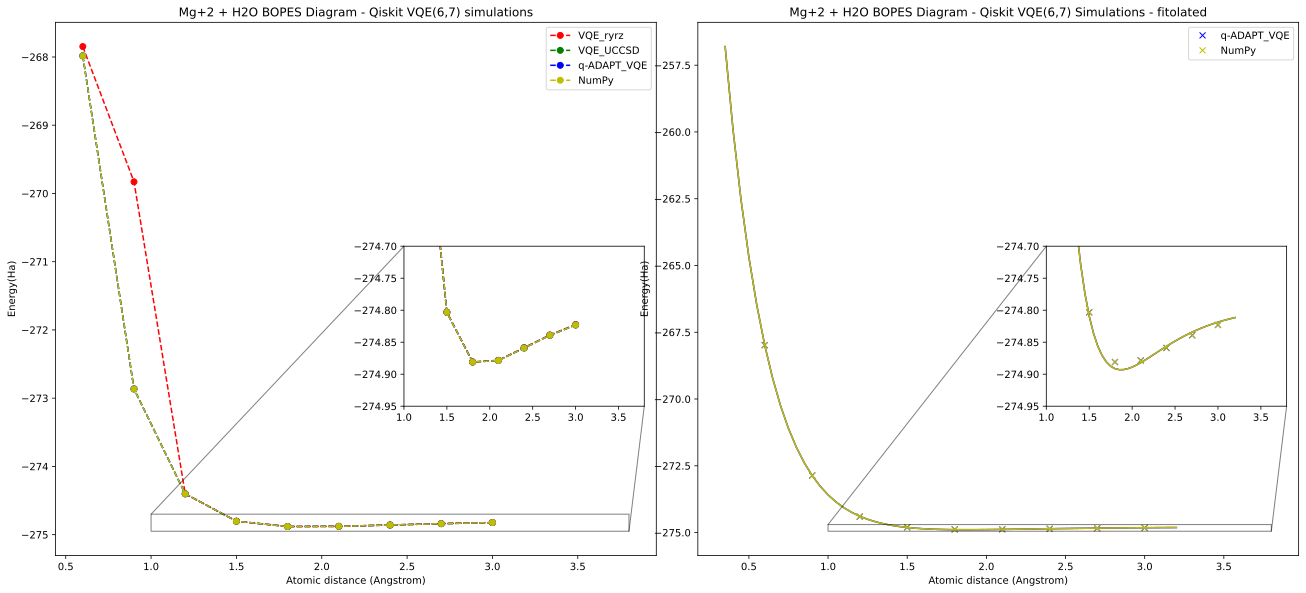

In [756]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_fit['ryrz']['popt'](x), 'r-',label='ryrz')

ax1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_fit['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_fit['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')
#ax1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='classic')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_fit['ryrz']['popt'](x), 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_fit['uccsd']['popt'](x), 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_fit['avqe']['popt'](x), 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')

xx1, xx2, yy1, yy2 = 1.0,3.8, -274.95, -274.7
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,qiskit_engs['avqe'],'bx',label='q-ADAPT_VQE')
#ax2.plot(x, qiskit_fit['avqe']['popt'](x), 'b-')
ax2.plot(x, qiskit_fit['avqe']['popt'](x), 'b-')

ax2.plot(distances,qiskit_engs['classic'],'yx',label='NumPy')
#ax2.plot(x, qiskit_fit['classic']['popt'](x), 'y-')
ax2.plot(x, qiskit_fit['classic']['popt'](x), 'y-')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) Simulations - fitolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_fit['avqe']['popt'](x), 'b-',label='avqe')

axins2.plot(distances,qiskit_engs['classic'],'yx')
#axins2.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='classic')
axins2.plot(x, qiskit_fit['classic']['popt'](x), 'y-')

#xx1, xx2, yy1, yy2 = .5,3.8, -276, -274
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2e3a36130>,
 (<matplotlib.patches.ConnectionPatch at 0x2e387a1f0>,
  <matplotlib.patches.ConnectionPatch at 0x2e2e9ad60>))

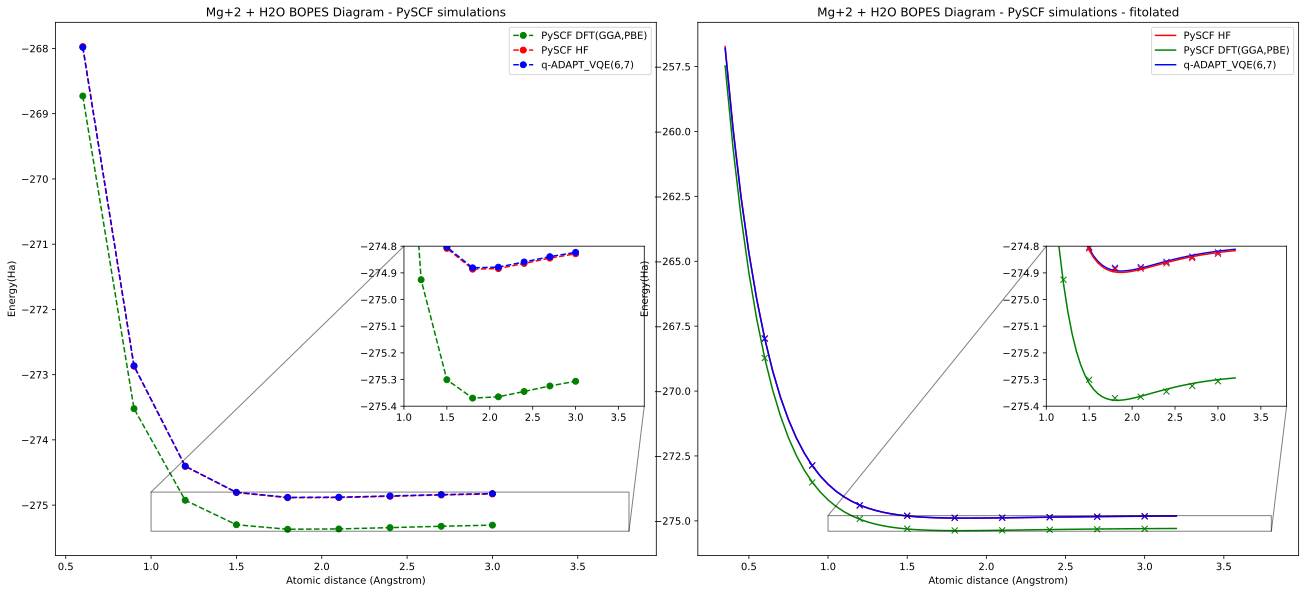

In [757]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')
#ax1.plot(x, qiskit_fit['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')
#ax1.plot(x, qiskit_fit['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')

axins1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')


xx1, xx2, yy1, yy2 = 1.0,3.8, -275.4, -274.8
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,pyscf_engs['HF'],'rx')
ax2.plot(x, pyscf_fit['HF']['popt'](x), 'r-',label='PySCF HF')

ax2.plot(distances,pyscf_engs['DFT'],'gx')
ax2.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax2.plot(distances,qiskit_engs['avqe'],'bx')
ax2.plot(x, qiskit_fit['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations - fitolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_fit['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

axins2.plot(distances,pyscf_engs['DFT'],'gx')
axins2.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT ')

axins2.plot(distances,pyscf_engs['HF'],'rx')
axins2.plot(x, pyscf_fit['HF']['popt'](x), 'r-',label='PySCF HF')

xx1, xx2, yy1, yy2 = 1.0,3.8, -275.4, -274.8
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2c1682eb0>,
 (<matplotlib.patches.ConnectionPatch at 0x2c7160070>,
  <matplotlib.patches.ConnectionPatch at 0x2c477a550>))

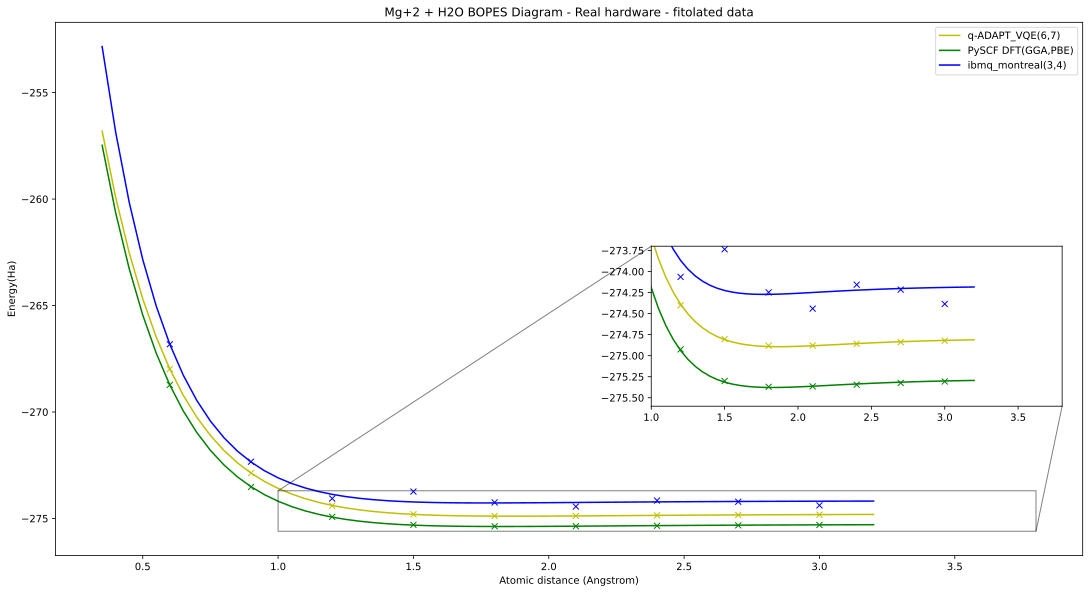

In [758]:
fig, ax1=plt.subplots(1,1,figsize=(15,8))
fig.tight_layout()

#####

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,qiskit_engs['avqe'],'yx')
ax1.plot(x, qiskit_fit['avqe']['popt'](x), 'y-',label='q-ADAPT_VQE(6,7)')

ax1.plot(distances,pyscf_engs['DFT'],'gx')
ax1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax1.plot(rdistances,real_engs['montreal'],'bx')
ax1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal(3,4)')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - fitolated data')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


axins1.plot(distances,qiskit_engs['classic'],'yx')
axins1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

axins1.plot(distances,pyscf_engs['DFT'],'gx')
axins1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

axins1.plot(rdistances,real_engs['montreal'],'bx')
axins1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal(3,4)')

xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [794]:
min_x=real_fit['montreal']['result'].params['re'].value
min_x_err=real_fit['montreal']['result'].params['re'].stderr
print(f'Equilibrium distance from ibmq_montreal(3,4) data: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')

Equilibrium distance from ibmq_montreal(3,4) data: 1.7680159361458823 +/- 0.3264419494303973
Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.870221152660597 +/- 0.013804747283741963
Equilibrium distance from NumPy calculation: 1.8698442264430752 +/- 0.012932481372847568
Equilibrium distance from PySCF DFT simulation: 1.8252087677355893 +/- 0.015392573677799627


Finally we export this data as .csv files

In [800]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
#df.index="Energy in Ha for"+distance
df.to_csv('MG+H2O/MG_H2O_data.csv', index=False, header=True)

In [801]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-267.964084,-268.728971,-267.970664,-267.982393,-267.983170,-266.819192,-267.846781,-267.983170
1,0.9,-272.861415,-273.521194,-272.870988,-272.863902,-272.865233,-272.334462,-269.828750,-272.865233
2,1.2,-274.398622,-274.925619,-274.406715,-274.401569,-274.401694,-274.064207,-274.401488,-274.401694
3,1.5,-274.800634,-275.300724,-274.808086,-274.803249,-274.803341,-273.736191,-274.803027,-274.803340
4,1.8,-274.878371,-275.369722,-274.886110,-274.880954,-274.881087,-274.248140,-274.880798,-274.881086
5,2.1,-274.875657,-275.364801,-274.883932,-274.878508,-274.878647,-274.441057,-274.878278,-274.878647
6,2.4,-274.855817,-275.344925,-274.864470,-274.858973,-274.859101,-274.157031,-274.858611,-274.859101
7,2.7,-274.835671,-275.324150,-274.844627,-274.839156,-274.839252,-274.215476,-274.838610,-274.839252
8,3.0,-274.819241,-275.306566,-274.828418,-274.823039,-274.823100,-274.385672,-274.822297,-274.823100


## Mg+CO2

We define a fitting function for this pair:

In [887]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=1.75,u0=-390)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 0.6
    morse_o_params['re'].max = 2.2
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [869]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Mg+CO2/simulations/ryrz_results')[1:10]
uccsd_results=read('Mg+CO2/simulations/uccsd_results')[1:10]
avqe_results=read('Mg+CO2/simulations/avqe_results')[1:10]
classic_results=read('Mg+CO2/simulations/classic_results')[1:10]
pyscf_energies=read('Mg+CO2/simulations/pyscf_energies')[1:10]
problems=read('Mg+CO2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

Read the PySCF simulation results

In [870]:
HF_engs=read('Mg+CO2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Mg+CO2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Mg+CO2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [871]:
# interpreted_results=read('Mg+CO2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [872]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [873]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [874]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [875]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [876]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [877]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

(<matplotlib.patches.Rectangle at 0x2e9b4e670>,
 (<matplotlib.patches.ConnectionPatch at 0x2e9ba6730>,
  <matplotlib.patches.ConnectionPatch at 0x2e9ba6fd0>))

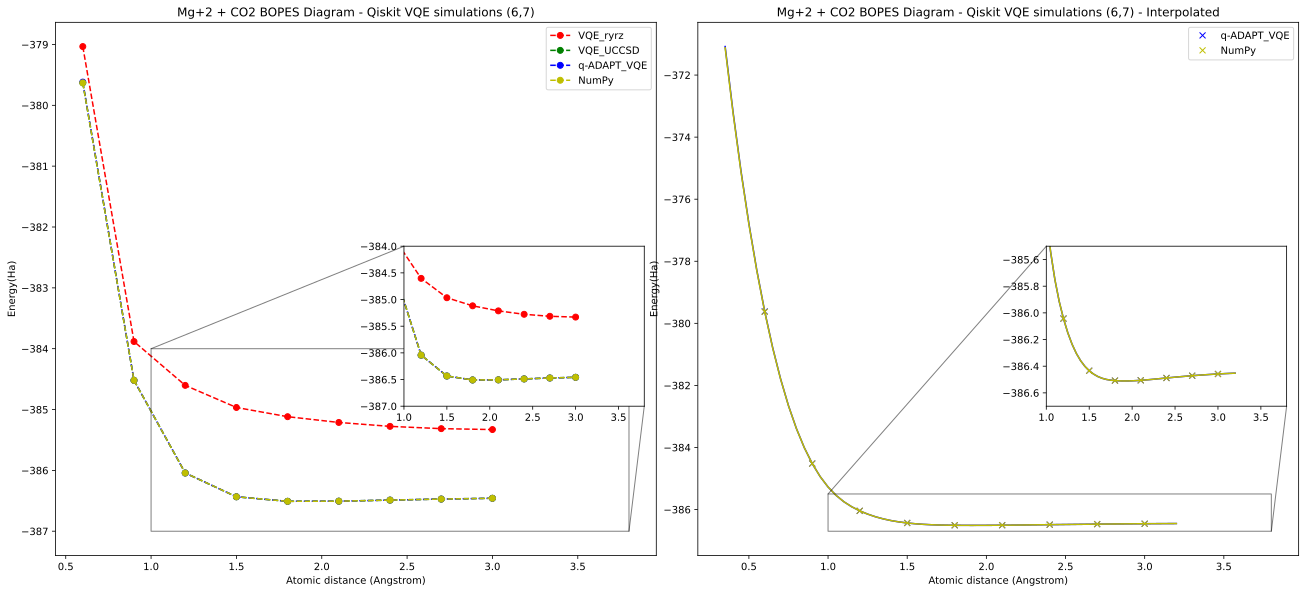

In [889]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

ax1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')
#ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + CO2 BOPES Diagram - Qiskit VQE simulations (6,7)')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')

xx1, xx2, yy1, yy2 = 1.0,3.8, -387, -384
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,qiskit_engs['avqe'],'bx',label='q-ADAPT_VQE')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-')

ax2.plot(distances,qiskit_engs['classic'],'yx',label='NumPy')
ax2.plot(x, qiskit_interp['classic']['popt'](x), 'y-')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + CO2 BOPES Diagram - Qiskit VQE simulations (6,7) - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins2.plot(distances,qiskit_engs['classic'],'yx')
axins2.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.8, -386.7, -385.5
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2e990f970>,
 (<matplotlib.patches.ConnectionPatch at 0x2e9912790>,
  <matplotlib.patches.ConnectionPatch at 0x2e9918400>))

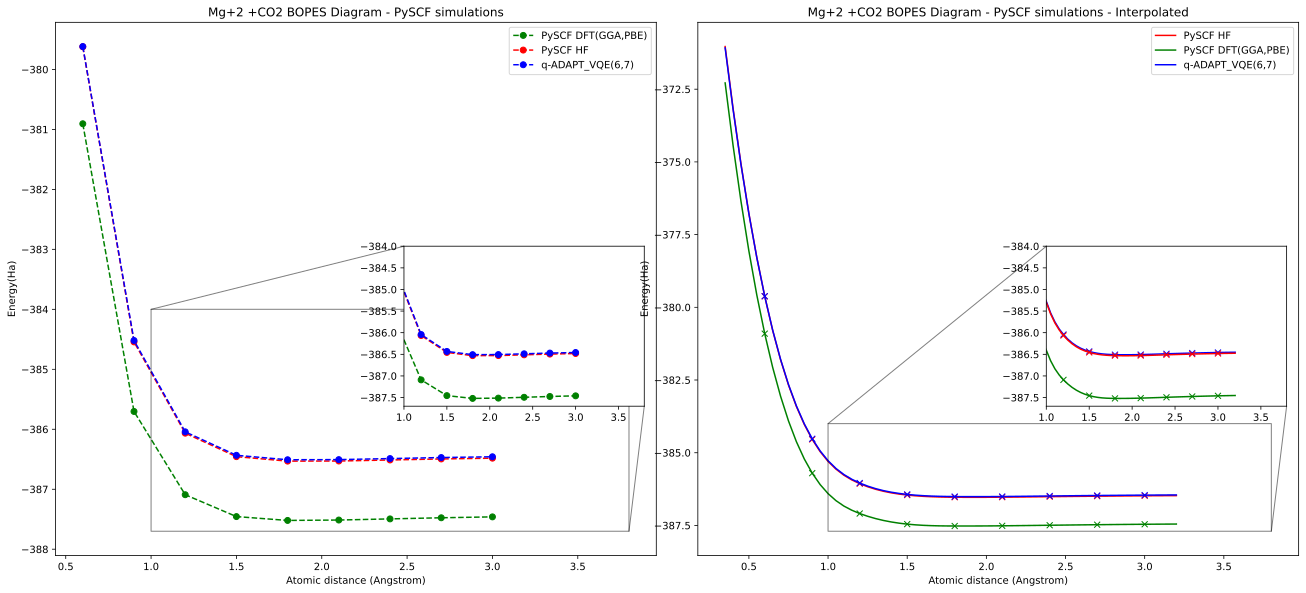

In [885]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 +CO2 BOPES Diagram - PySCF simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')

axins1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')


xx1, xx2, yy1, yy2 = 1.0,3.8, -387.7, -384
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,pyscf_engs['HF'],'rx')
ax2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

ax2.plot(distances,pyscf_engs['DFT'],'gx')
ax2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax2.plot(distances,qiskit_engs['avqe'],'bx')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 +CO2 BOPES Diagram - PySCF simulations - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

axins2.plot(distances,pyscf_engs['DFT'],'gx')
axins2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT ')

axins2.plot(distances,pyscf_engs['HF'],'rx')
axins2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')


axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


In [880]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [890]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.8596678603698304 +/- 0.016223384237088984
Equilibrium distance from NumPy calculation: 1.8607401634830518 +/- 0.016340164480458455
Equilibrium distance from PySCF DFT simulation: 1.8133323352531994 +/- 0.01841111469405783


Finally we export this data as .csv files

In [891]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
#df.index="Energy in Ha for"+distance
df.to_csv('MG+CO2/MG+CO2_data.csv', index=False, header=True)

In [892]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-379.713308,-380.905721,-379.621851,-379.618250,-379.630181,-266.819192,-379.033924,-379.630181
1,0.9,-384.617968,-385.703083,-384.543177,-384.519852,-384.520063,-272.334462,-383.882090,-384.520063
2,1.2,-386.137063,-387.091178,-386.065097,-386.042609,-386.042703,-274.064207,-384.602730,-386.042703
3,1.5,-386.527874,-387.455794,-386.456399,-386.434026,-386.434086,-273.736191,-384.965974,-386.434086
4,1.8,-386.601104,-387.520109,-386.531026,-386.508099,-386.508169,-274.248140,-385.117486,-386.508168
5,2.1,-386.597819,-387.513414,-386.529347,-386.505981,-386.506067,-274.441057,-385.212295,-386.506066
6,2.4,-386.579671,-387.494390,-386.511974,-386.488436,-386.488518,-274.157031,-385.276608,-386.488518
7,2.7,-386.562403,-387.475726,-386.494935,-386.471415,-386.471470,-274.215476,-385.314015,-386.471470
8,3.0,-386.549329,-387.460669,-386.481732,-386.458354,-386.458382,-274.385672,-385.328966,-386.458382


## Mg+N2

We write a function to fit the data

In [923]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-310)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [894]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Mg+N2/simulations/ryrz_results')[1:10]
uccsd_results=read('Mg+N2/simulations/uccsd_results')[1:10]
avqe_results=read('Mg+N2/simulations/avqe_results')[1:10]
classic_results=read('Mg+N2/simulations/classic_results')[1:10]
pyscf_energies=read('Mg+N2/simulations/pyscf_energies')[1:10]
problems=read('Mg+N2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

Read the PySCF simulation results

In [895]:
HF_engs=read('Mg+N2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Mg+N2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Mg+N2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [896]:
# interpreted_results=read('Mg+N2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [897]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [898]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [899]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [908]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [924]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [910]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

(<matplotlib.patches.Rectangle at 0x2c2321160>,
 (<matplotlib.patches.ConnectionPatch at 0x2c234d340>,
  <matplotlib.patches.ConnectionPatch at 0x2e5cd9ee0>))

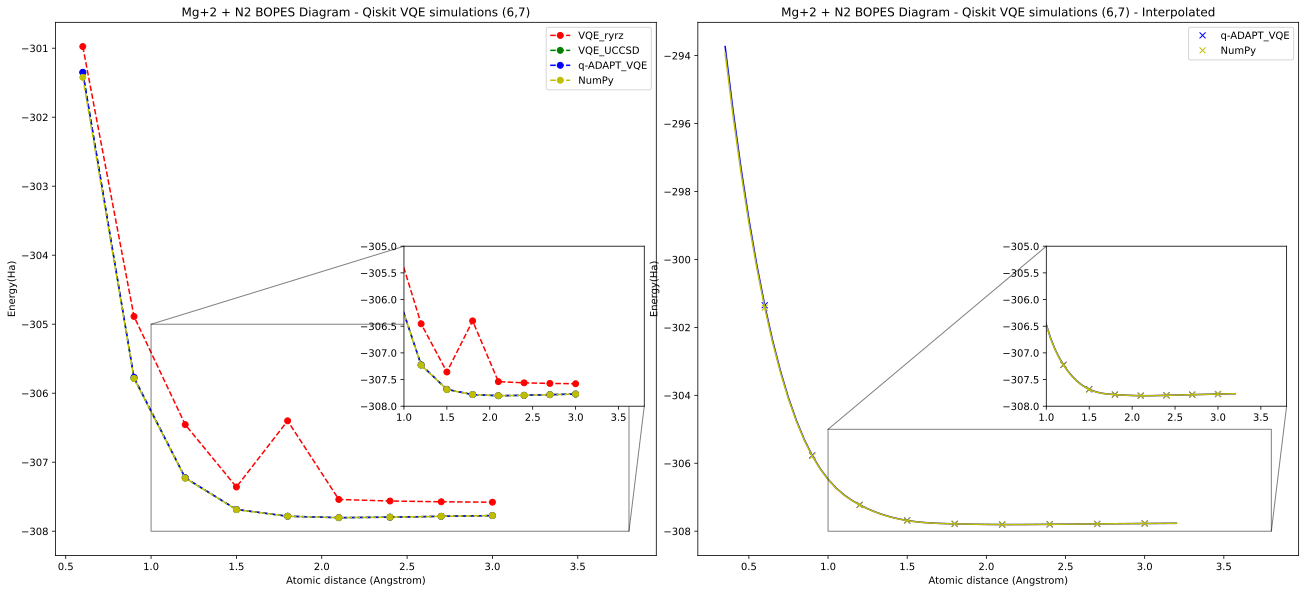

In [911]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

ax1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')
#ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + N2 BOPES Diagram - Qiskit VQE simulations (6,7)')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')

xx1, xx2, yy1, yy2 = 1.0,3.8, -308, -305
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,qiskit_engs['avqe'],'bx',label='q-ADAPT_VQE')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-')

ax2.plot(distances,qiskit_engs['classic'],'yx',label='NumPy')
ax2.plot(x, qiskit_interp['classic']['popt'](x), 'y-')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + N2 BOPES Diagram - Qiskit VQE simulations (6,7) - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins2.plot(distances,qiskit_engs['classic'],'yx')
axins2.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2e2632460>,
 (<matplotlib.patches.ConnectionPatch at 0x2e2b233a0>,
  <matplotlib.patches.ConnectionPatch at 0x2e2cf1bb0>))

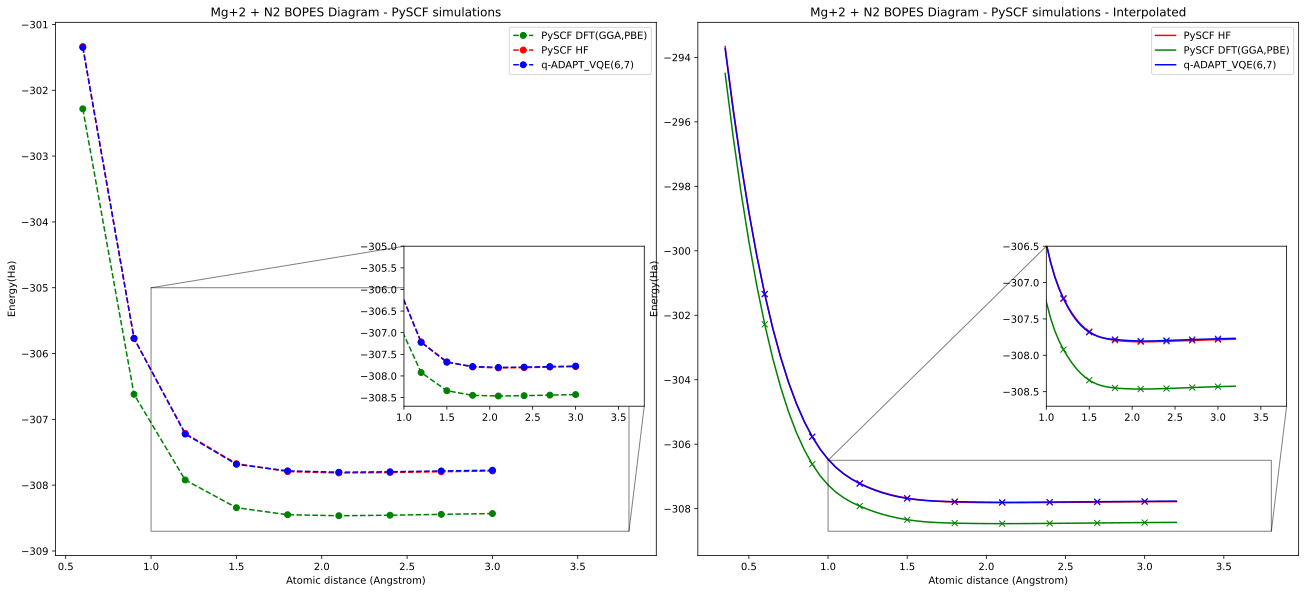

In [925]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + N2 BOPES Diagram - PySCF simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')

axins1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')


xx1, xx2, yy1, yy2 = 1.0,3.8, -308.7, -305
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,pyscf_engs['HF'],'rx')
ax2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

ax2.plot(distances,pyscf_engs['DFT'],'gx')
ax2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax2.plot(distances,qiskit_engs['avqe'],'bx')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + N2 BOPES Diagram - PySCF simulations - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,pyscf_engs['HF'],'rx')
axins2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

axins2.plot(distances,pyscf_engs['DFT'],'gx')
axins2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT ')

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

xx1, xx2, yy1, yy2 = 1.0,3.8, -308.7, -306.5
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


In [913]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [926]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.950827794247213 +/- 0.03761811547294868
Equilibrium distance from NumPy calculation: 1.9520103658760617 +/- 0.035914622287818464
Equilibrium distance from PySCF DFT simulation: 1.898832966376383 +/- 0.06543173715174


Finally we export this data as .csv files

In [927]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Mg+N2/Mg+N2_data.csv', index=False, header=True)

In [928]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-301.473145,-302.281500,-301.335358,-301.348523,-301.421935,-266.819192,-300.975813,-301.352461
1,0.9,-305.900722,-306.619915,-305.769282,-305.769397,-305.785432,-272.334462,-304.887281,-305.785431
2,1.2,-307.353267,-307.921279,-307.212963,-307.223876,-307.229671,-274.064207,-306.454919,-307.229671
3,1.5,-307.812717,-308.342500,-307.673098,-307.683356,-307.686903,-273.736191,-307.358917,-307.686902
4,1.8,-307.933790,-308.449184,-307.793745,-307.782616,-307.782779,-274.248140,-306.400127,-307.782779
5,2.1,-307.954539,-308.464424,-307.814643,-307.803225,-307.803445,-274.441057,-307.539575,-307.803445
6,2.4,-307.947368,-308.456806,-307.808063,-307.796444,-307.796678,-274.157031,-307.562132,-307.796678
7,2.7,-307.934060,-308.443812,-307.795783,-307.784050,-307.784248,-274.215476,-307.573165,-307.784248
8,3.0,-307.921641,-308.431494,-307.784653,-307.772849,-307.772982,-274.385672,-307.579198,-307.772982


## Zn+H2O

We write a function to fit the data

In [937]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-310)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [938]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Zn+H2O/simulations/ryrz_results')[1:10]
uccsd_results=read('Zn+H2O/simulations/uccsd_results')[1:10]
avqe_results=read('Zn+H2O/simulations/avqe_results')[1:10]
classic_results=read('Zn+H2O/simulations/classic_results')[1:10]
pyscf_energies=read('Zn+H2O/simulations/pyscf_energies')[1:10]
problems=read('Zn+H2O/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [939]:
print(avqe_energies)

[-1841.5139410332881, -1850.1690719812573, -1852.1512646145893, -1852.610662587871, -1852.6902545992132, -1852.6836216847398, -1852.6601974619257, -1852.637654276882, -1852.334132162829]


Read the PySCF simulation results

In [940]:
HF_engs=read('Zn+H2O/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Zn+H2O/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Zn+H2O/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [941]:
# interpreted_results=read('Zn+H2O/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [942]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [943]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [944]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [945]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [946]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [947]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

(<matplotlib.patches.Rectangle at 0x2e9c381c0>,
 (<matplotlib.patches.ConnectionPatch at 0x2bf1d6df0>,
  <matplotlib.patches.ConnectionPatch at 0x2e28d10d0>))

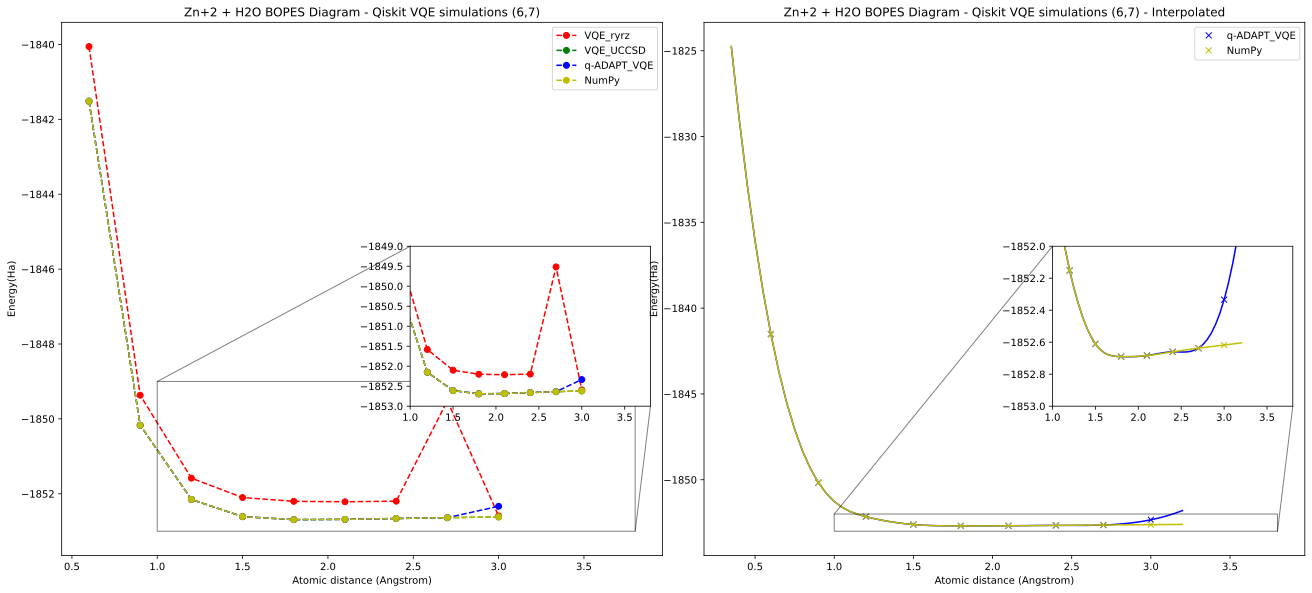

In [948]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

ax1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')
#ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + H2O BOPES Diagram - Qiskit VQE simulations (6,7)')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1853, -1849
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,qiskit_engs['avqe'],'bx',label='q-ADAPT_VQE')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-')

ax2.plot(distances,qiskit_engs['classic'],'yx',label='NumPy')
ax2.plot(x, qiskit_interp['classic']['popt'](x), 'y-')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + H2O BOPES Diagram - Qiskit VQE simulations (6,7) - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins2.plot(distances,qiskit_engs['classic'],'yx')
axins2.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1853, -1852
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2e71ac070>,
 (<matplotlib.patches.ConnectionPatch at 0x2e7135220>,
  <matplotlib.patches.ConnectionPatch at 0x2e7114a30>))

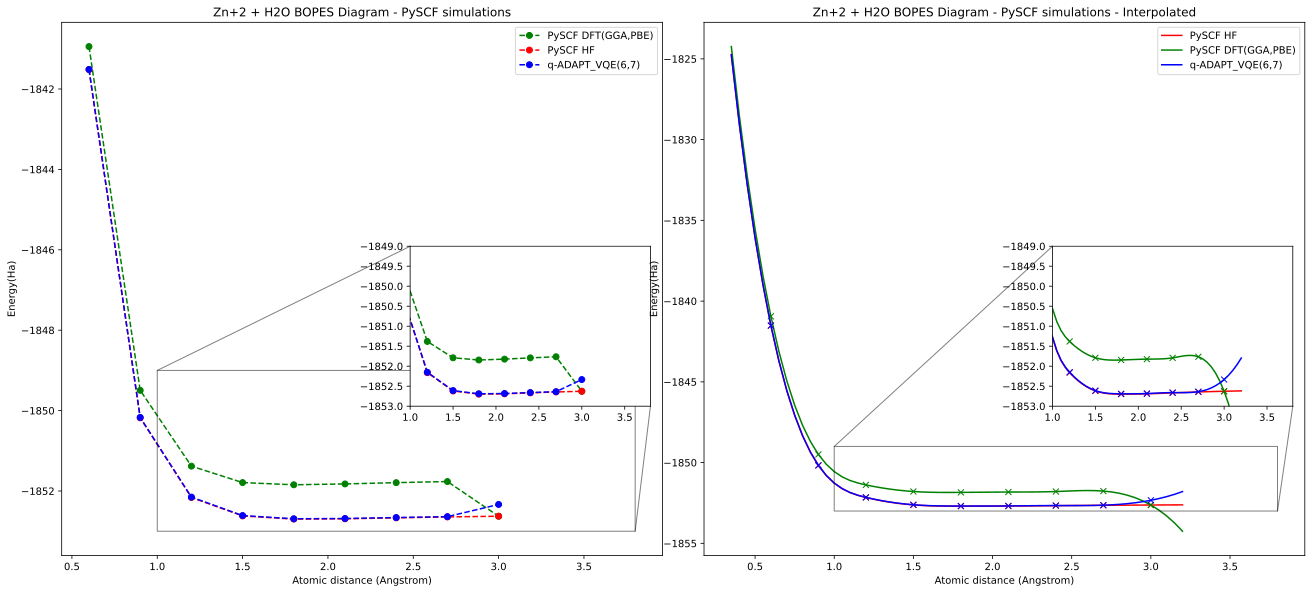

In [950]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + H2O BOPES Diagram - PySCF simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')

axins1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')


xx1, xx2, yy1, yy2 = 1.0,3.8, -1853, -1849
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,pyscf_engs['HF'],'rx')
ax2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

ax2.plot(distances,pyscf_engs['DFT'],'gx')
ax2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax2.plot(distances,qiskit_engs['avqe'],'bx')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + H2O BOPES Diagram - PySCF simulations - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,pyscf_engs['HF'],'rx')
axins2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

axins2.plot(distances,pyscf_engs['DFT'],'gx')
axins2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT ')

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1853, -1849
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


In [951]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [953]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.6859873540260235 +/- 0.0940239852609806
Equilibrium distance from NumPy calculation: 1.7316305780854795 +/- 0.04726366047873322
Equilibrium distance from PySCF DFT simulation: 1.7305325452034082 +/- 0.3910064252241787


Finally we export this data as .csv files

In [954]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Zn+H2O/Zn+H2O_data.csv', index=False, header=True)

In [955]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1841.515512,-1840.943805,-1841.515832,-1841.513941,-1841.514919,-266.819192,-1840.055542,-1841.514919
1,0.9,-1850.179120,-1849.495639,-1850.179508,-1850.169072,-1850.169207,-272.334462,-1849.367678,-1850.169207
2,1.2,-1852.161078,-1851.381191,-1852.161130,-1852.151265,-1852.151362,-274.064207,-1851.582409,-1852.151362
3,1.5,-1852.613977,-1851.790049,-1852.619460,-1852.610663,-1852.610771,-273.736191,-1852.100636,-1852.610771
4,1.8,-1852.698222,-1851.844863,-1852.698525,-1852.690255,-1852.690346,-274.248140,-1852.201396,-1852.690346
5,2.1,-1852.691644,-1851.823562,-1852.691111,-1852.683622,-1852.683712,-274.441057,-1852.213400,-1852.683712
6,2.4,-1852.666377,-1851.791906,-1852.667333,-1852.660197,-1852.660286,-274.157031,-1852.197662,-1852.660286
7,2.7,-1852.642020,-1851.764144,-1852.644598,-1852.637654,-1852.637748,-274.215476,-1849.516321,-1852.637748
8,3.0,-1852.641973,-1852.626946,-1852.626946,-1852.334132,-1852.617833,-274.385672,-1852.592602,-1852.617686


## Zn+CO2

We write a function to fit the data

In [957]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-310)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [958]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Zn+CO2/simulations/ryrz_results')[1:10]
uccsd_results=read('Zn+CO2/simulations/uccsd_results')[1:10]
avqe_results=read('Zn+CO2/simulations/avqe_results')[1:10]
classic_results=read('Zn+CO2/simulations/classic_results')[1:10]
pyscf_energies=read('Zn+CO2/simulations/pyscf_energies')[1:10]
problems=read('Zn+CO2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [959]:
print(avqe_energies)

[-1953.177480844024, -1961.8124301730732, -1963.7834467098212, -1964.2372108637915, -1964.3153417580643, -1964.3089355933018, -1964.2878742736093, -1964.2646999690446, -1963.556142840442]


Read the PySCF simulation results

In [960]:
HF_engs=read('Zn+CO2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Zn+CO2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Zn+CO2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [961]:
# interpreted_results=read('Zn+CO2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [962]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [963]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [964]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [965]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [966]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [967]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

(<matplotlib.patches.Rectangle at 0x2e2b29fd0>,
 (<matplotlib.patches.ConnectionPatch at 0x2edca8e50>,
  <matplotlib.patches.ConnectionPatch at 0x2edcb0d00>))

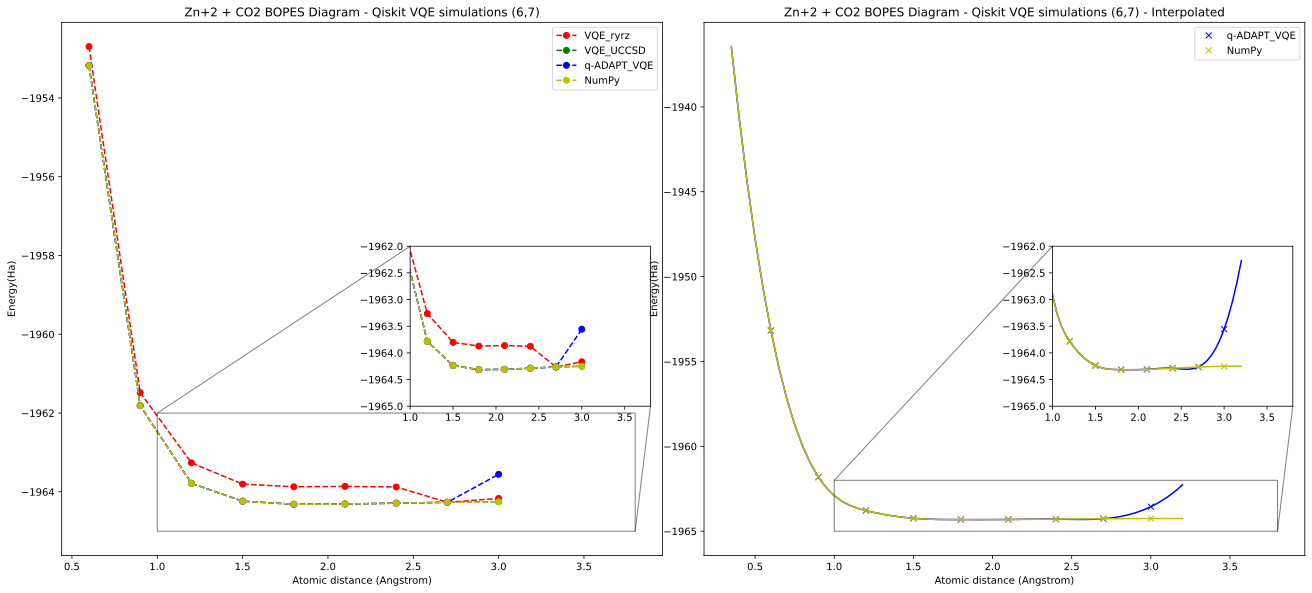

In [968]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

ax1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')
#ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + CO2 BOPES Diagram - Qiskit VQE simulations (6,7)')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1965, -1962
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,qiskit_engs['avqe'],'bx',label='q-ADAPT_VQE')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-')

ax2.plot(distances,qiskit_engs['classic'],'yx',label='NumPy')
ax2.plot(x, qiskit_interp['classic']['popt'](x), 'y-')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + CO2 BOPES Diagram - Qiskit VQE simulations (6,7) - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins2.plot(distances,qiskit_engs['classic'],'yx')
axins2.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1965, -1962
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2ec984520>,
 (<matplotlib.patches.ConnectionPatch at 0x2eccfbee0>,
  <matplotlib.patches.ConnectionPatch at 0x2ecd05340>))

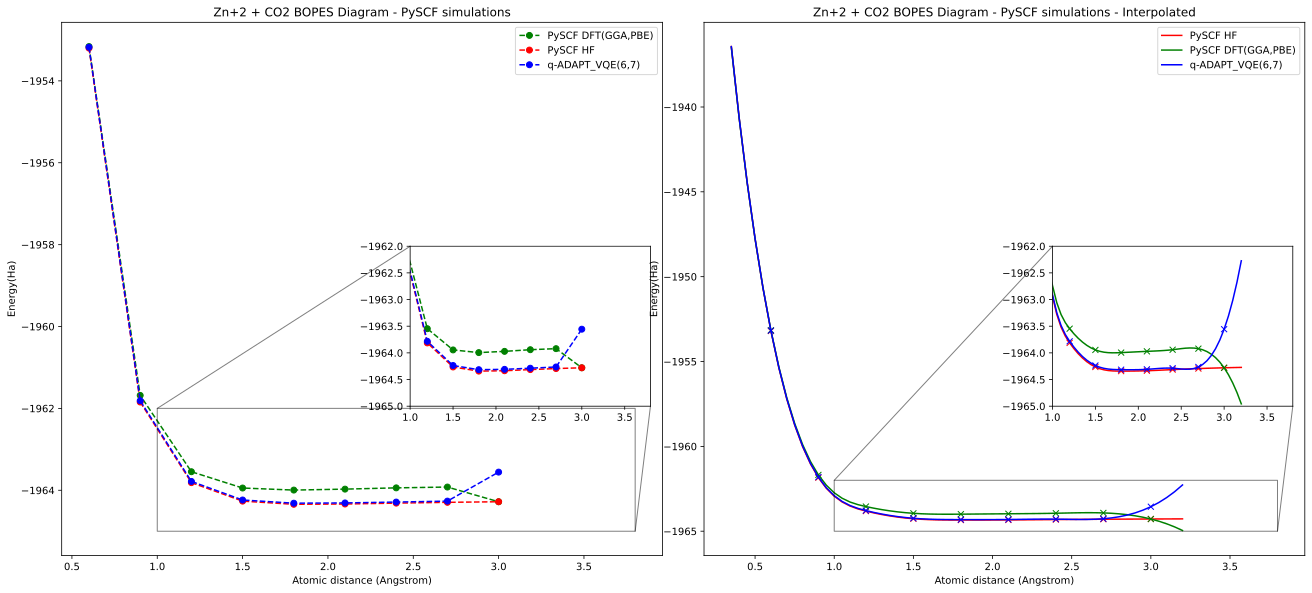

In [969]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + CO2 BOPES Diagram - PySCF simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')

axins1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')


xx1, xx2, yy1, yy2 = 1.0,3.8, -1965, -1962
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,pyscf_engs['HF'],'rx')
ax2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

ax2.plot(distances,pyscf_engs['DFT'],'gx')
ax2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax2.plot(distances,qiskit_engs['avqe'],'bx')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + CO2 BOPES Diagram - PySCF simulations - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,pyscf_engs['HF'],'rx')
axins2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

axins2.plot(distances,pyscf_engs['DFT'],'gx')
axins2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT ')

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')


axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


In [970]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [972]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.5807945832484949 +/- 0.08368657522396498
Equilibrium distance from NumPy calculation: 1.7336068363789383 +/- 0.053167796928673475
Equilibrium distance from PySCF DFT simulation: 1.7074791641780611 +/- 0.16690812049503057


Finally we export this data as .csv files

In [973]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Zn+CO2/Zn+CO2_data.csv', index=False, header=True)

In [974]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1953.328354,-1953.161517,-1953.199054,-1953.177481,-1953.180211,-266.819192,-1952.694355,-1953.180211
1,0.9,-1961.957938,-1961.682518,-1961.843990,-1961.812430,-1961.813001,-272.334462,-1961.482131,-1961.813001
2,1.2,-1963.922971,-1963.546852,-1963.813270,-1963.783447,-1963.783924,-274.064207,-1963.263639,-1963.783924
3,1.5,-1964.379958,-1963.944830,-1964.264902,-1964.237211,-1964.237456,-273.736191,-1963.803868,-1964.237455
4,1.8,-1964.460590,-1963.995065,-1964.342359,-1964.315342,-1964.315542,-274.248140,-1963.872433,-1964.315542
5,2.1,-1964.451853,-1963.971852,-1964.335356,-1964.308936,-1964.309212,-274.441057,-1963.862826,-1964.309212
6,2.4,-1964.428047,-1963.940853,-1964.313856,-1964.287874,-1964.288095,-274.157031,-1963.876759,-1964.288094
7,2.7,-1964.358684,-1963.921025,-1964.294374,-1964.264700,-1964.265511,-274.215476,-1964.264934,-1964.265511
8,3.0,-1964.301702,-1964.280056,-1964.280056,-1963.556143,-1964.251321,-274.385672,-1964.167544,-1964.250832


## Zn+N2

We write a function to fit the data

In [1016]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=1.5,u0=-1885)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = .3
    morse_o_params['re'].max = 3.0
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [976]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Zn+N2/simulations/ryrz_results')[1:10]
uccsd_results=read('Zn+N2/simulations/uccsd_results')[1:10]
avqe_results=read('Zn+N2/simulations/avqe_results')[1:10]
classic_results=read('Zn+N2/simulations/classic_results')[1:10]
pyscf_energies=read('Zn+N2/simulations/pyscf_energies')[1:10]
problems=read('Zn+N2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [977]:
print(avqe_energies)

[-1875.604342542135, -1883.27655272432, -1885.0259402291501, -1885.4952292068135, -1885.6031593484893, -1885.613499134299, -1885.5998014566899, -1885.5828616187448, -1885.5683409901828]


Read the PySCF simulation results

In [978]:
HF_engs=read('Zn+N2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Zn+N2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Zn+N2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [979]:
# interpreted_results=read('Zn+N2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [980]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [1017]:
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])

In [981]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [982]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [983]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [984]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [985]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

(<matplotlib.patches.Rectangle at 0x2ec9465e0>,
 (<matplotlib.patches.ConnectionPatch at 0x2c4b3d070>,
  <matplotlib.patches.ConnectionPatch at 0x2c46b8250>))

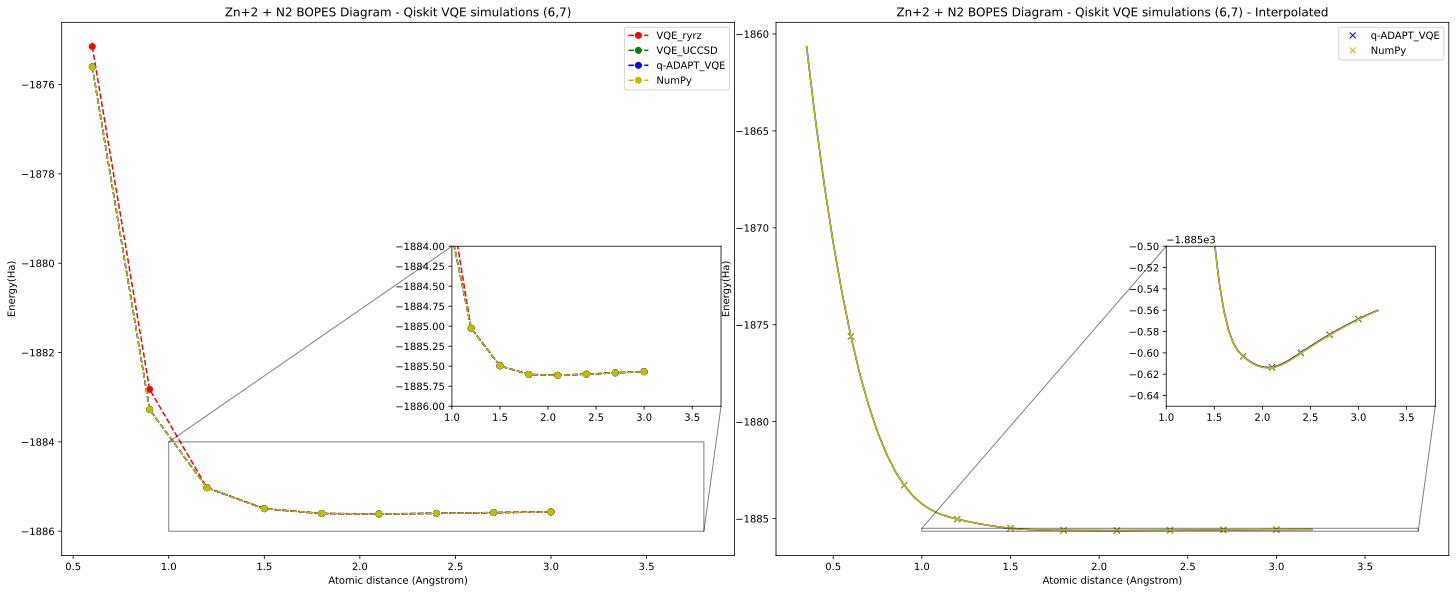

In [1018]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(20,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

ax1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')
#ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + N2 BOPES Diagram - Qiskit VQE simulations (6,7)')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1886, -1884
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,qiskit_engs['avqe'],'bx',label='q-ADAPT_VQE')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-')

ax2.plot(distances,qiskit_engs['classic'],'yx',label='NumPy')
ax2.plot(x, qiskit_interp['classic']['popt'](x), 'y-')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + N2 BOPES Diagram - Qiskit VQE simulations (6,7) - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins2.plot(distances,qiskit_engs['classic'],'yx')
axins2.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1885.65, -1885.5
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2ed706f10>,
 (<matplotlib.patches.ConnectionPatch at 0x2ed719a90>,
  <matplotlib.patches.ConnectionPatch at 0x2ed71e0d0>))

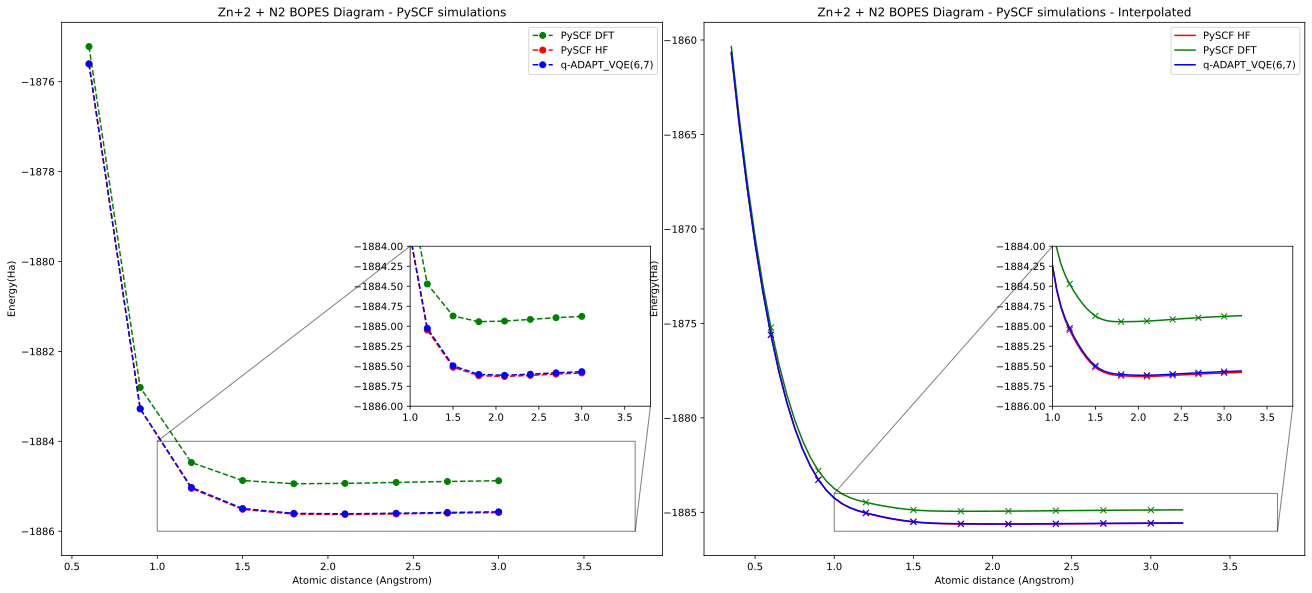

In [987]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + N2 BOPES Diagram - PySCF simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')

axins1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')


xx1, xx2, yy1, yy2 = 1.0,3.8, -1886, -1884
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,pyscf_engs['HF'],'rx')
ax2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

ax2.plot(distances,pyscf_engs['DFT'],'gx')
ax2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax2.plot(distances,qiskit_engs['avqe'],'bx')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Zn+2 + N2 BOPES Diagram - PySCF simulations - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,pyscf_engs['HF'],'rx')
axins2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

axins2.plot(distances,pyscf_engs['DFT'],'gx')
axins2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT ')

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')


axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


In [988]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [1019]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.7415578968207321 +/- 0.08820845216297621
Equilibrium distance from NumPy calculation: 2.4873456519296067 +/- 1.4403113402155334
Equilibrium distance from PySCF DFT simulation: 1.691976913465691 +/- 0.058005869038885466


Finally we export this data as .csv files

In [1020]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Zn+N2/Zn+N2_data.csv', index=False, header=True)

In [1021]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1875.737739,-1875.218214,-1875.603628,-1875.604343,-1875.608927,-266.819192,-1875.150208,-1875.608927
1,0.9,-1883.452837,-1882.802587,-1883.276229,-1883.276553,-1883.278310,-272.334462,-1882.824726,-1883.278310
2,1.2,-1885.211194,-1884.471916,-1885.047845,-1885.025940,-1885.026425,-274.064207,-1885.026002,-1885.026425
3,1.5,-1885.664445,-1884.871963,-1885.513434,-1885.495229,-1885.495543,-273.736191,-1885.495246,-1885.495542
4,1.8,-1885.768410,-1884.943562,-1885.619010,-1885.603159,-1885.603505,-274.248140,-1885.603191,-1885.603505
5,2.1,-1885.784252,-1884.936068,-1885.628619,-1885.613499,-1885.614070,-274.441057,-1885.613576,-1885.614070
6,2.4,-1885.772280,-1884.914740,-1885.615008,-1885.599801,-1885.600507,-274.157031,-1885.599317,-1885.600507
7,2.7,-1885.752671,-1884.893728,-1885.598642,-1885.582862,-1885.583481,-274.215476,-1885.582541,-1885.583480
8,3.0,-1885.733453,-1884.877220,-1885.584968,-1885.568341,-1885.568809,-274.385672,-1885.568172,-1885.568809


## Cu+H2O

We write a function to fit the data

In [1022]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-1800)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [1023]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Cu+H2O/simulations/ryrz_results')[1:10]
uccsd_results=read('Cu+H2O/simulations/uccsd_results')[1:10]
avqe_results=read('Cu+H2O/simulations/avqe_results')[1:10]
classic_results=read('Cu+H2O/simulations/classic_results')[1:10]
pyscf_energies=read('Cu+H2O/simulations/pyscf_energies')[1:10]
problems=read('Cu+H2O/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [1024]:
print(avqe_energies)

[-1703.2604796405092, -1711.463143842524, -1713.3237101802292, -1713.7845972128628, -1713.8481731687289, -1713.843902946498, -1713.7852711906262, -1713.6391578351588, -1713.70374481601]


Read the PySCF simulation results

In [1025]:
HF_engs=read('Cu+H2O/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Cu+H2O/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Cu+H2O/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [1026]:
# interpreted_results=read('Cu+H2O/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [1027]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [1028]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [1029]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [1030]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [1031]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [1032]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

(<matplotlib.patches.Rectangle at 0x2f2977970>,
 (<matplotlib.patches.ConnectionPatch at 0x2f2833b80>,
  <matplotlib.patches.ConnectionPatch at 0x2f282bcd0>))

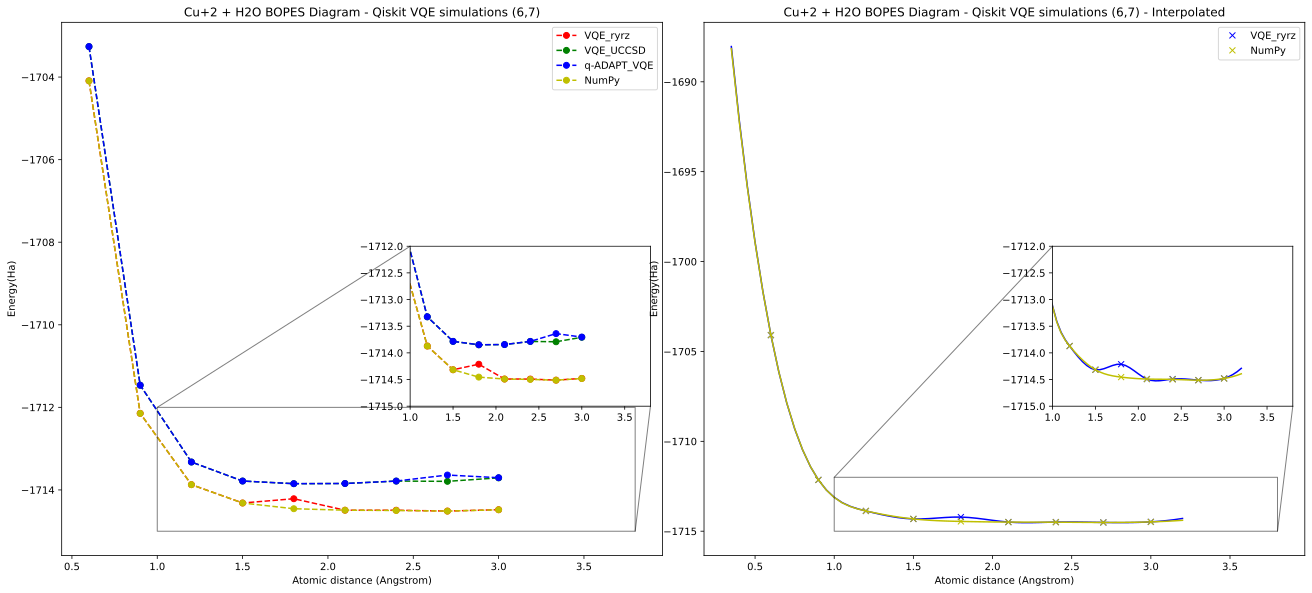

In [1033]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

ax1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')
#ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + H2O BOPES Diagram - Qiskit VQE simulations (6,7)')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1715, -1712
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,qiskit_engs['ryrz'],'bx',label='VQE_ryrz')
ax2.plot(x, qiskit_interp['ryrz']['popt'](x), 'b-')

ax2.plot(distances,qiskit_engs['classic'],'yx',label='NumPy')
ax2.plot(x, qiskit_interp['classic']['popt'](x), 'y-')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + H2O BOPES Diagram - Qiskit VQE simulations (6,7) - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['ryrz'],'bx')
axins2.plot(x, qiskit_interp['ryrz']['popt'](x), 'b-',label='VQE_ryrz')

axins2.plot(distances,qiskit_engs['classic'],'yx')
axins2.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2ee114100>,
 (<matplotlib.patches.ConnectionPatch at 0x2ee180700>,
  <matplotlib.patches.ConnectionPatch at 0x29c94a790>))

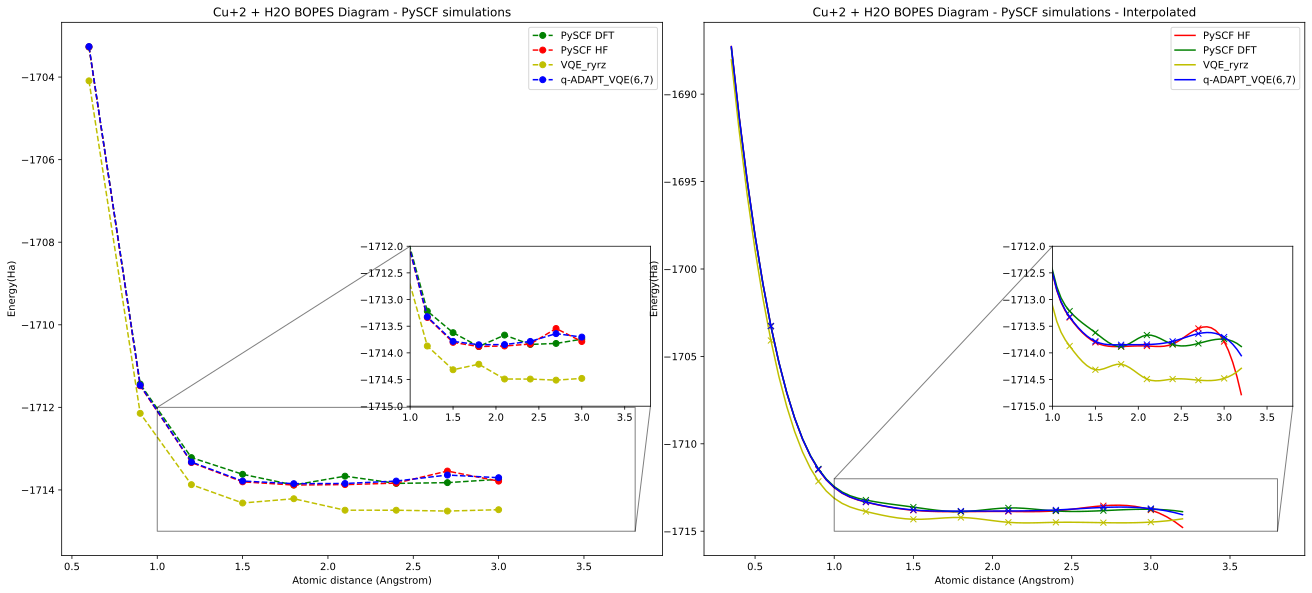

In [1034]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['ryrz'],'yo--',label='VQE_ryrz')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + H2O BOPES Diagram - PySCF simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')

axins1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')

axins1.plot(distances,qiskit_engs['ryrz'],'yo--',label='VQE_ryrz')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')



xx1, xx2, yy1, yy2 = 1.0,3.8, -1715, -1712
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,pyscf_engs['HF'],'rx')
ax2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

ax2.plot(distances,pyscf_engs['DFT'],'gx')
ax2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax2.plot(distances,qiskit_engs['ryrz'],'yx')
ax2.plot(x, qiskit_interp['ryrz']['popt'](x), 'y-',label='VQE_ryrz')

ax2.plot(distances,qiskit_engs['avqe'],'bx')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + H2O BOPES Diagram - PySCF simulations - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,pyscf_engs['HF'],'rx')
axins2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

axins2.plot(distances,pyscf_engs['DFT'],'gx')
axins2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT ')

axins2.plot(distances,qiskit_engs['ryrz'],'yx')
axins2.plot(x, qiskit_interp['ryrz']['popt'](x), 'y-',label='VQE_ryrz')

axins2.plot(distances,qiskit_engs['avqe'],'bx',label='q-ADAPT_VQE(6,7)')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-')


axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


In [1035]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [1037]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.7061123654248052 +/- 0.06462687894349542
Equilibrium distance from NumPy calculation: 1.744784522938982 +/- 0.08281938601148665
Equilibrium distance from PySCF DFT simulation: 1.737117388269911 +/- 0.16334899696344263


Finally we export this data as .csv files

In [1038]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Cu+H2O/Cu+H2O_data.csv', index=False, header=True)

In [1039]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1703.320480,-1703.271616,-1703.269644,-1703.260480,-1704.091083,-266.819192,-1704.090883,-1703.261812
1,0.9,-1711.484010,-1711.435233,-1711.477245,-1711.463144,-1712.145872,-272.334462,-1712.144713,-1711.464320
2,1.2,-1713.342295,-1713.216911,-1713.336798,-1713.323710,-1713.871924,-274.064207,-1713.871924,-1713.323839
3,1.5,-1713.801597,-1713.621026,-1713.803621,-1713.784597,-1714.316884,-273.736191,-1714.316623,-1713.784706
4,1.8,-1713.894923,-1713.881076,-1713.881076,-1713.848173,-1714.454893,-274.248140,-1714.213099,-1713.848766
5,2.1,-1713.853831,-1713.666675,-1713.870900,-1713.843903,-1714.491027,-274.441057,-1714.491025,-1713.844308
6,2.4,-1713.856244,-1713.841771,-1713.834979,-1713.785271,-1714.497570,-274.157031,-1714.491421,-1713.785568
7,2.7,-1713.837892,-1713.823119,-1713.542689,-1713.639158,-1714.512718,-274.215476,-1714.511729,-1713.791882
8,3.0,-1713.758468,-1713.743472,-1713.787086,-1713.703745,-1714.480723,-274.385672,-1714.478940,-1713.707829


## Cu+CO2

In [1040]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-1800)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [1041]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Cu+Co2/simulations/ryrz_results')[1:10]
uccsd_results=read('Cu+Co2/simulations/uccsd_results')[1:10]
avqe_results=read('Cu+Co2/simulations/avqe_results')[1:10]
classic_results=read('Cu+Co2/simulations/classic_results')[1:10]
pyscf_energies=read('Cu+CO2/simulations/pyscf_energies')[1:10]
problems=read('Cu+Co2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [1042]:
print(avqe_energies)

[-1814.9272867277334, -1823.0915385800604, -1824.9182307648755, -1825.3775394901722, -1825.4475357141935, -1825.4327570738346, -1825.4092929426924, -1825.372046198568, -1823.193357723379]


Read the PySCF simulation results

In [1043]:
HF_engs=read('Cu+Co2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Cu+Co2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Cu+Co2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [1044]:
# interpreted_results=read('Cu+Co2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [1045]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [1046]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [1047]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [1048]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [1049]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [1050]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

(<matplotlib.patches.Rectangle at 0x2e7faefd0>,
 (<matplotlib.patches.ConnectionPatch at 0x2e3b1b7f0>,
  <matplotlib.patches.ConnectionPatch at 0x2e9286340>))

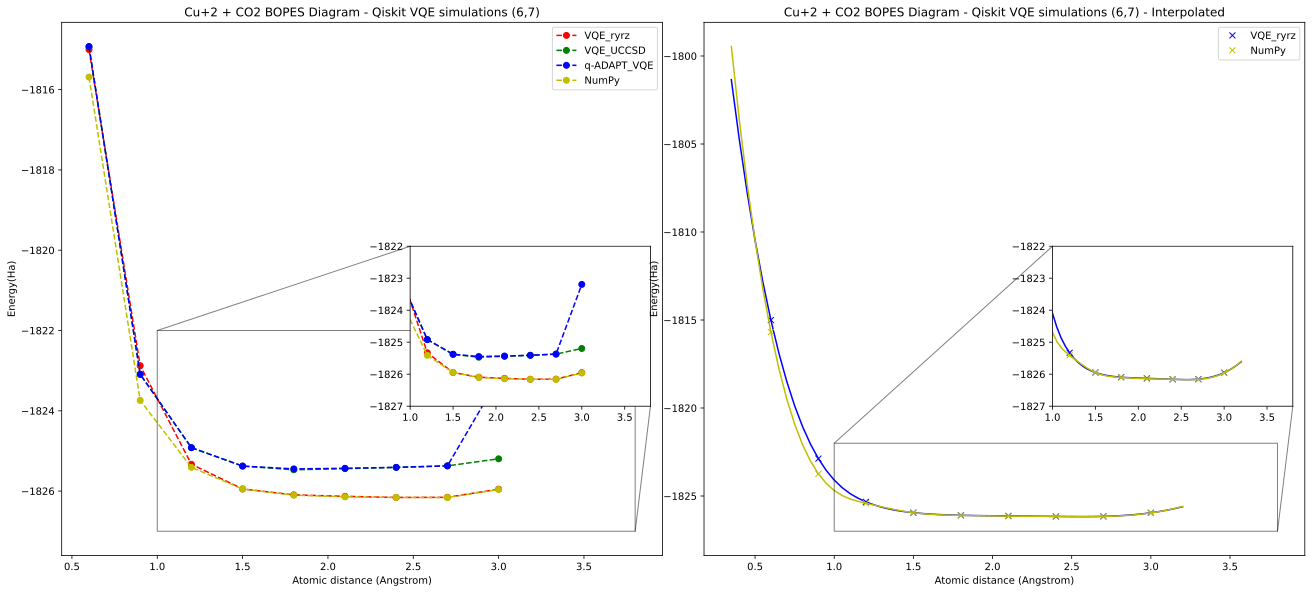

In [1051]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

ax1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')
#ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + CO2 BOPES Diagram - Qiskit VQE simulations (6,7)')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1827, -1822
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,qiskit_engs['ryrz'],'bx',label='VQE_ryrz')
ax2.plot(x, qiskit_interp['ryrz']['popt'](x), 'b-')

ax2.plot(distances,qiskit_engs['classic'],'yx',label='NumPy')
ax2.plot(x, qiskit_interp['classic']['popt'](x), 'y-')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + CO2 BOPES Diagram - Qiskit VQE simulations (6,7) - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['ryrz'],'bx',label='VQE_ryrz')
axins2.plot(x, qiskit_interp['ryrz']['popt'](x), 'b-')

axins2.plot(distances,qiskit_engs['classic'],'yx')
axins2.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')


axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2f414af40>,
 (<matplotlib.patches.ConnectionPatch at 0x2f418a1f0>,
  <matplotlib.patches.ConnectionPatch at 0x2f41aca60>))

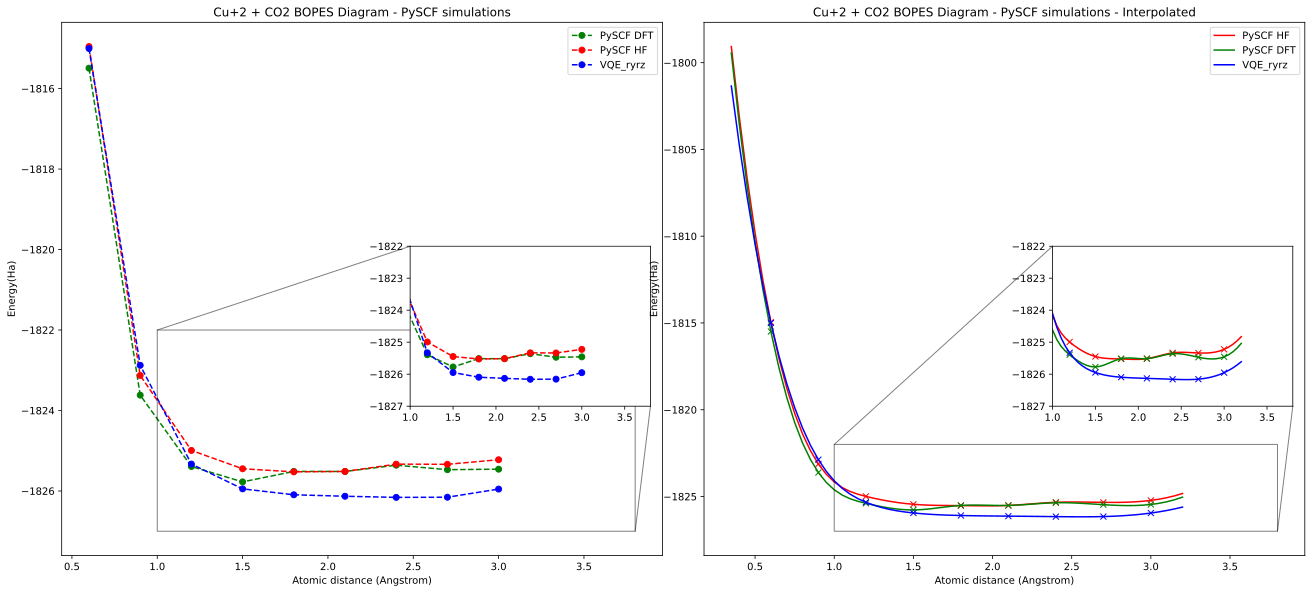

In [1052]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['ryrz'],'bo--',label='VQE_ryrz')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + CO2 BOPES Diagram - PySCF simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')

axins1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')

axins1.plot(distances,qiskit_engs['ryrz'],'bo--',label='vqe_ryrz')


xx1, xx2, yy1, yy2 = 1.0,3.8, -1827, -1822

axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,pyscf_engs['HF'],'rx')
ax2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

ax2.plot(distances,pyscf_engs['DFT'],'gx')
ax2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax2.plot(distances,qiskit_engs['ryrz'],'bx')
ax2.plot(x, qiskit_interp['ryrz']['popt'](x), 'b-',label='VQE_ryrz')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + CO2 BOPES Diagram - PySCF simulations - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))



axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,pyscf_engs['HF'],'rx')
axins2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

axins2.plot(distances,pyscf_engs['DFT'],'gx')
axins2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT ')

axins2.plot(distances,qiskit_engs['ryrz'],'bx')
axins2.plot(x, qiskit_interp['ryrz']['popt'](x), 'b-',label='VQE_ryrz')


axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


In [1053]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [1054]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.5245930183746106 +/- 0.11608471904342539
Equilibrium distance from NumPy calculation: 1.7588430873755139 +/- 0.16398593982858276
Equilibrium distance from PySCF DFT simulation: 1.508568708921952 +/- 0.029134812550463476


Finally we export this data as .csv files

In [1055]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Cu+Co2/Cu+Co2_data.csv', index=False, header=True)

In [1056]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1815.090704,-1815.493235,-1814.955484,-1814.927287,-1815.687981,-266.819192,-1815.003346,-1814.932397
1,0.9,-1823.257638,-1823.618611,-1823.128268,-1823.091539,-1823.740688,-272.334462,-1822.876270,-1823.092127
2,1.2,-1825.088236,-1825.391727,-1824.992292,-1824.918231,-1825.409864,-274.064207,-1825.331689,-1824.919127
3,1.5,-1825.523506,-1825.773683,-1825.447956,-1825.377539,-1825.947402,-273.736191,-1825.947400,-1825.377741
4,1.8,-1825.538070,-1825.514331,-1825.524349,-1825.447536,-1826.101603,-274.248140,-1826.094402,-1825.470555
5,2.1,-1825.537762,-1825.514754,-1825.514754,-1825.432757,-1826.142788,-274.441057,-1826.130919,-1825.441537
6,2.4,-1825.401102,-1825.359205,-1825.333107,-1825.409293,-1826.159016,-274.157031,-1826.159004,-1825.410151
7,2.7,-1825.492411,-1825.470559,-1825.336974,-1825.372046,-1826.162002,-274.215476,-1826.155115,-1825.372129
8,3.0,-1825.479742,-1825.458080,-1825.223814,-1823.193358,-1825.961735,-274.385672,-1825.952823,-1825.196337


## Cu+N2

In [1057]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-1800)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [1058]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Cu+N2/simulations/ryrz_results')[1:10]
uccsd_results=read('Cu+N2/simulations/uccsd_results')[1:10]
avqe_results=read('Cu+N2/simulations/avqe_results')[1:10]
classic_results=read('Cu+N2/simulations/classic_results')[1:10]
pyscf_energies=read('Cu+N2/simulations/pyscf_energies')[1:10]
problems=read('Cu+N2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [1059]:
print(avqe_energies)

[-1737.398768454305, -1744.6593893718914, -1746.2221349663726, -1746.6618731720323, -1746.7738568474024, -1746.7702964549471, -1746.7475735824664, -1746.380484340334, -1746.6913496662196]


Read the PySCF simulation results

In [1060]:
HF_engs=read('Cu+N2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Cu+N2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Cu+N2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [1061]:
# interpreted_results=read('Cu+N2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [1062]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2884: RuntimeWarning: overflow encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2877: RuntimeWarning: overflow encountered in double_scalars
  tmp1 = (xb - xa) * (fb - fc)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2884: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2878: RuntimeWarning: overflow encountered in double_scalars
  tmp2 = (xb - xc) * (fb - fa)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2879: RuntimeWarning: inv

In [1063]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [1064]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [1065]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [1066]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [1067]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

(<matplotlib.patches.Rectangle at 0x2e904fd90>,
 (<matplotlib.patches.ConnectionPatch at 0x2e75ba250>,
  <matplotlib.patches.ConnectionPatch at 0x2ec86b3a0>))

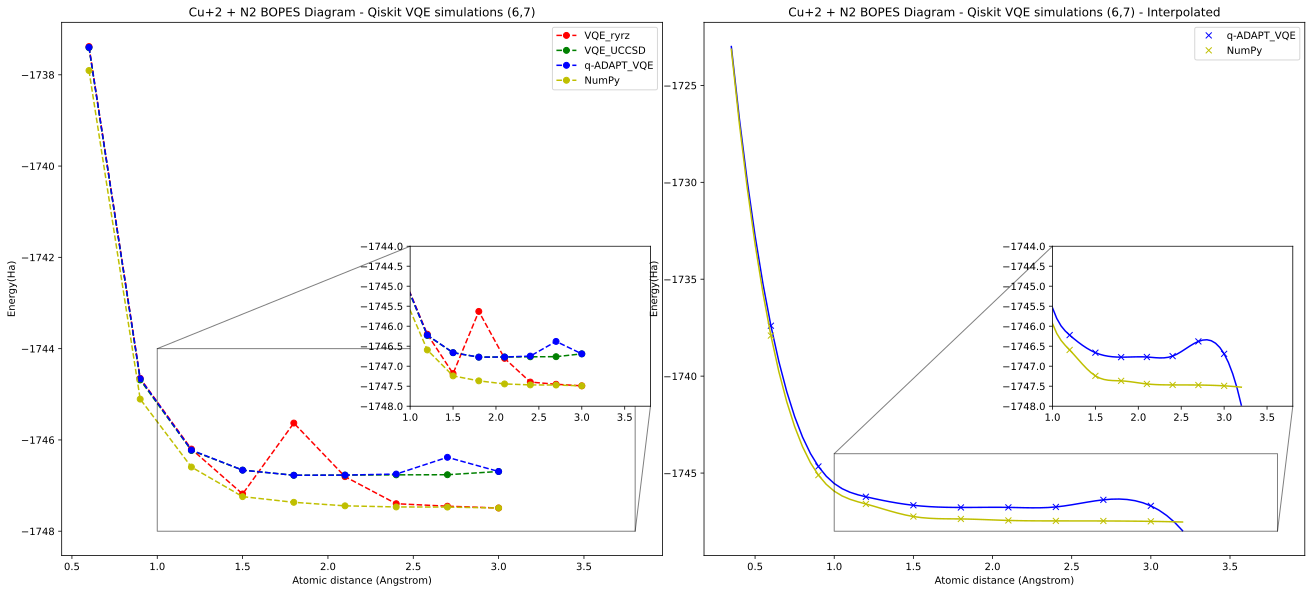

In [1068]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

ax1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')
#ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + N2 BOPES Diagram - Qiskit VQE simulations (6,7)')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz'],'ro--',label='VQE_ryrz')
# ax.plot(x, qiskit_interp['ryrz']['popt'](x), 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd'],'go--',label='VQE_UCCSD')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic'],'yo--',label='NumPy')

xx1, xx2, yy1, yy2 = 1.0,3.8, -1748, -1744
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,qiskit_engs['avqe'],'bx',label='q-ADAPT_VQE')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-')

ax2.plot(distances,qiskit_engs['classic'],'yx',label='NumPy')
ax2.plot(x, qiskit_interp['classic']['popt'](x), 'y-')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + N2 BOPES Diagram - Qiskit VQE simulations (6,7) - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

axins2.plot(distances,qiskit_engs['classic'],'yx')
axins2.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='classic')

axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


(<matplotlib.patches.Rectangle at 0x2e24a1100>,
 (<matplotlib.patches.ConnectionPatch at 0x2e91a51c0>,
  <matplotlib.patches.ConnectionPatch at 0x2e7f86220>))

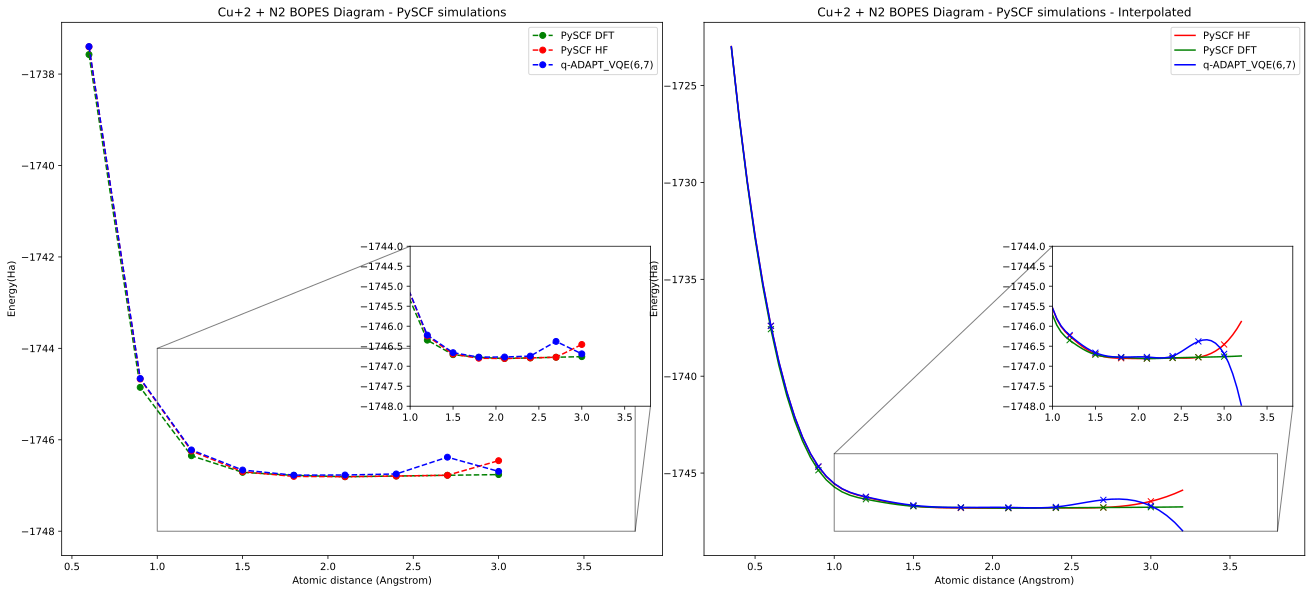

In [1069]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ((ax1,ax2))=plt.subplots(1,2,figsize=(18,8))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')
#ax1.plot(x, qiskit_interp['uccsd']['popt'](x), 'g-',label='uccsd')

ax1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')
#ax1.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='avqe')

ax1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + N2 BOPES Diagram - PySCF simulations')
ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT'],'go--',label='PySCF DFT')

axins1.plot(distances,pyscf_engs['HF'],'ro--',label='PySCF HF')

axins1.plot(distances,qiskit_engs['avqe'],'bo--',label='q-ADAPT_VQE(6,7)')


xx1, xx2, yy1, yy2 = 1.0,3.8, -1748, -1744
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)

ax1.indicate_inset_zoom(axins1, edgecolor="black")

######ax2

ax2.plot(distances,pyscf_engs['HF'],'rx')
ax2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

ax2.plot(distances,pyscf_engs['DFT'],'gx')
ax2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

ax2.plot(distances,qiskit_engs['avqe'],'bx')
ax2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')

ax2.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Cu+2 + N2 BOPES Diagram - PySCF simulations - Interpolated')
ax2.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


axins2 = ax2.inset_axes([0.58, 0.28, 0.4, 0.3])

axins2.plot(distances,pyscf_engs['HF'],'rx')
axins2.plot(x, pyscf_interp['HF']['popt'](x), 'r-',label='PySCF HF')

axins2.plot(distances,pyscf_engs['DFT'],'gx')
axins2.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT ')

axins2.plot(distances,qiskit_engs['avqe'],'bx')
axins2.plot(x, qiskit_interp['avqe']['popt'](x), 'b-',label='q-ADAPT_VQE(6,7)')


axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)

ax2.indicate_inset_zoom(axins2, edgecolor="black")


In [1070]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_interp['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_interp['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_interp['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [1072]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.7011413203042598 +/- 0.15882432955284864
Equilibrium distance from NumPy calculation: 1.8274401848438764 +/- 0.21373534321670426
Equilibrium distance from PySCF DFT simulation: 1.676729264923817 +/- 0.08640573605766134


Finally we export this data as .csv files

In [1073]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Cu+N2/Cu+N2_data.csv', index=False, header=True)

In [1074]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1737.528471,-1737.573682,-1737.405114,-1737.398768,-1737.906663,-266.819192,-1737.381506,-1737.404514
1,0.9,-1744.884649,-1744.853471,-1744.671183,-1744.659389,-1745.105681,-272.334462,-1744.650514,-1744.685308
2,1.2,-1746.435897,-1746.349196,-1746.243932,-1746.222135,-1746.593785,-274.064207,-1746.200358,-1746.231231
3,1.5,-1746.849630,-1746.712303,-1746.698102,-1746.661873,-1747.242359,-273.736191,-1747.184279,-1746.662018
4,1.8,-1746.933247,-1746.778368,-1746.801240,-1746.773857,-1747.366514,-274.248140,-1745.630396,-1746.773977
5,2.1,-1746.975240,-1746.807987,-1746.807987,-1746.770296,-1747.443699,-274.441057,-1746.804116,-1746.770572
6,2.4,-1746.961110,-1746.792947,-1746.792947,-1746.747574,-1747.468133,-274.157031,-1747.397330,-1746.764890
7,2.7,-1746.943682,-1746.776258,-1746.776258,-1746.380484,-1747.471159,-274.215476,-1747.451667,-1746.762209
8,3.0,-1746.926399,-1746.761495,-1746.457062,-1746.691350,-1747.491289,-274.385672,-1747.491286,-1746.691663
